In [11]:
# SETUP

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [12]:
INPUT_FILENAME = 'connectivity_classifier-SVM_cv-100x4fold'

RESULTS = xr.open_dataset('models/' + INPUT_FILENAME + '.nc5').load()

In [13]:
# prep results

n_subjects = RESULTS['X'].size
X = RESULTS['X'].values
y = RESULTS['y'].values

n_runs = RESULTS['cv_dim'].size
cv_test_size = 8 # TODO RESULTS['cv_test_size'].item()
scoring = 'accuracy' # TODO RESULTS['scoring'].item()

# find split score columns
split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_accuracy', c)]

# extract scores
scores = RESULTS[split_score_cols +
                 ['rank_test_accuracy', 'mean_test_accuracy', 'model_name']].to_pandas()
scores['test_accuracy'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_accuracy').reset_index(drop=True)
scores = scores.sort_values('rank_test_accuracy', ascending=False)

# add atlas kind, tagg, and cagg
scores['atlas'] = scores['model_name'].apply(lambda x: x.split('_')[0])
scores['kind'] = scores['model_name'].apply(lambda x: x.split('_')[1].split('-')[1])
scores['tagg'] = scores['model_name'].apply(lambda x: x.split('_')[2].split('-')[1])
scores['cagg'] = scores['model_name'].apply(lambda x: x.split('_')[3].split('-')[1])

# select only relevant columns
scores = scores[['model_name', 'atlas', 'kind', 'test_accuracy', 'mean_test_accuracy', 'tagg', 'cagg']]

# simulate chance (dummy classifier)
chance_model = DummyClassifier(strategy='stratified').fit(X, y)
chance_scores = cross_val_score(chance_model, X, y,
                                cv=StratifiedShuffleSplit(n_splits=n_runs, test_size=cv_test_size), 
                                scoring=scoring)

chance_scores = pd.DataFrame(chance_scores * 100.0, columns=['accuracy_pct'])
# chance_scores['atlas'] = chance_scores['model_name'].apply(lambda x: x.split('_')[0])
# chance_scores['kind'] = chance_scores['model_name'].apply(lambda x: x.split('_')[1].replace('kind-',''))

# percentage accuracy
scores['accuracy_pct'] = scores['test_accuracy'] * 100.0

# sort, mean score and ordering
scores = scores.sort_values('accuracy_pct', ascending=True)

In [14]:
# Calculate and report 95% confidence intervals

from scipy.stats import bootstrap
import numpy as np

def calculate_ci(scores):
    bootstrap_ci = bootstrap((scores.values,), np.mean, confidence_level=0.95, method='percentile')

    return bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high

scores.groupby(['atlas', 'kind', 'tagg', 'cagg'])['accuracy_pct'].apply(calculate_ci)

atlas          kind                tagg     cagg   
dosenbach2010  correlation         network  none       (56.625, 61.875)
                                   random   none         (48.5, 54.125)
                                   region   network      (50.0, 56.375)
                                            none       (45.375, 52.125)
                                            random      (47.75, 53.875)
               covariance          network  none          (49.5, 55.75)
                                   random   none       (46.125, 51.625)
                                   region   network       (47.5, 53.25)
                                            none        (40.75, 47.625)
                                            random       (43.625, 49.5)
               partialcorrelation  network  none        (69.75, 74.625)
                                   random   none       (46.625, 51.875)
                                   region   network     (47.375, 53.25)
            

FixedFormatter should only be used together with FixedLocator


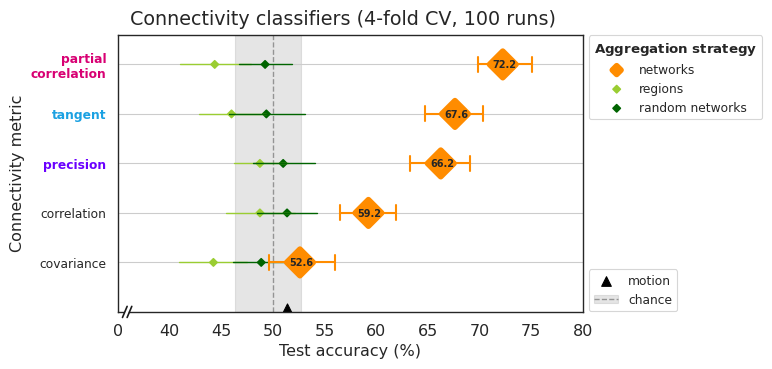

In [28]:
# plot

sns.set('paper', 'white')
fig, ax = plt.subplots(figsize=(6, 6 * .6))


network_scores = scores.query('tagg == "network" and cagg == "none"')
network_mean_scores = network_scores.groupby('kind')['accuracy_pct'].mean().reset_index()
order = network_mean_scores.sort_values('accuracy_pct', ascending=False)['kind'].values

# network model scores
network_plt = sns.pointplot(data=network_scores,
              x='accuracy_pct', y='kind', order=order,
              join=False,
              color='darkorange',
              markers='D',
              capsize=0.3,
              errwidth=1.5,
              scale=2.5,
              errorbar=('ci', 95),
              ax=ax,
              label='networks')

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, kind, accuracy_pct in network_mean_scores.itertuples():
    ticklabel_idx = y_ticklabels.index(kind)
    network_plt.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-1.05, ticklabel_idx+.07), weight='bold', size=7, zorder=102)

plt.setp(network_plt.lines, zorder=100)
plt.setp(network_plt.collections, zorder=101)

# baseline scores (regions)
region_scores = scores.query('tagg == "region" and cagg == "none"')
region_plt = sns.pointplot(data=region_scores, x='accuracy_pct', y='kind',
              markers='D', scale=.7, errwidth=1,
              join=False, color='yellowgreen', ax=ax, order=order, label='regions')

# baseline scores (random networks)
random_scores = scores.query('tagg == "random" and cagg == "none"')
random_plt = sns.pointplot(data=random_scores, x='accuracy_pct', y='kind',
              markers='D', scale=.7, errwidth=1,
              join=False, color='darkgreen', ax=ax, order=order, label='random networks')

# chance (theoretical and empirical)
tchance_plt = ax.axvline(x=50, linestyle='--', color='gray',
           linewidth=1, alpha=.8, zorder=-1)
echance_plt = ax.axvspan(*calculate_ci(chance_scores['accuracy_pct']),
           alpha=0.2, color='gray', zorder=-1,
           label=None)

# motion confounds classifier
motion_accuracy = 51.4  # see the corresponding notebook
motion_plt = ax.scatter([motion_accuracy], [4.95], marker='^', s=64, color='black')

# model names on y-axis ticks
ax.grid(axis='y')
ax.set_yticklabels([l.replace('partial', 'partial\n') for l in y_ticklabels])

# axis labels
ax.set_ylim(5, -.6)
ax.set_xlim(35, 80)
ax.set_ylabel('Connectivity metric', fontsize='large')
ax.set_xlabel('Test accuracy (%)', fontsize='large')
plt.xticks(fontsize='large')

# y-tick colors
plt.setp(ax.get_yticklabels()[0], color='#D80073', fontweight='bold')
plt.setp(ax.get_yticklabels()[1], color='#1BA1E2', fontweight='bold')
plt.setp(ax.get_yticklabels()[2], color='#6A00FF', fontweight='bold')

# legend
bottom_legend = ax.legend(handles=[motion_plt, (tchance_plt, echance_plt)],
          labels=["motion", "chance"],
          loc='lower left', bbox_to_anchor=(1, -.02))
ax.add_artist(bottom_legend)

top_legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02),
                       title='$\\bf{Aggregation\ strategy}$')
top_legend.legend_handles[0]._sizes = [20]
bottom_legend.legend_handles[0]._sizes = [48]

# break x-axis

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, clip_on=False)
ax.plot(.018, -.0, marker=(2, 1, -20), markersize=5, color='w', zorder=100, **kwargs) # empty space
ax.plot((.02, .01), (.02, -.02), color='k', zorder=101, **kwargs)        # diagonal
ax.plot((.03, .02), (.02, -.02), color='k', zorder=101, **kwargs)        # diagonal
# add '0' label to the left of the break
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '0'
ax.set_xticklabels(labels)

# title
plt.suptitle(f'Connectivity classifiers (4-fold CV, {n_runs} runs)', fontsize='x-large', y=.95)
# save the figure
plt.savefig(f'outputs/figures/fig2_{INPUT_FILENAME}.png',
            dpi=300,
            bbox_inches='tight')
